# Pattern Recognition 1 - Expert System

**Objectives**

* Create a working image analysis and pattern recognition pipeline
* Object labelisation and feature extraction
* Creating an Expert System for Optical Character Recognition (OCR)

**Libraries needed for this lab**

* Numpy
* Matplotlib
* Scikit-image

(all included in the Anaconda distribution)

Idée des labs : on reçoit une image et on utilise technique pour les analyses

et idée est de créer OCR : image d'un texte et on veut automatiquement lire le texte et donc on a un string à la fin qui contient les caractères

au début : on va lire les lettres et les classifier et voir comment on peut extraire les infos importantes qu'on aura beosin pour faire la classification

idée : séparer les lettres du background, séparer les différentes lettres, trouver leur position, l'ordre, ... et en gros avoir des règles pour savoir quelle lettre correspond à quel caractère. bref on veut lire le texte. mais donc c'est low level les4 premiers tps, sans machine learning et apèrs on se focusera sur classification avec ML.

## Object detection

Given the following image :

(851, 1068) uint8


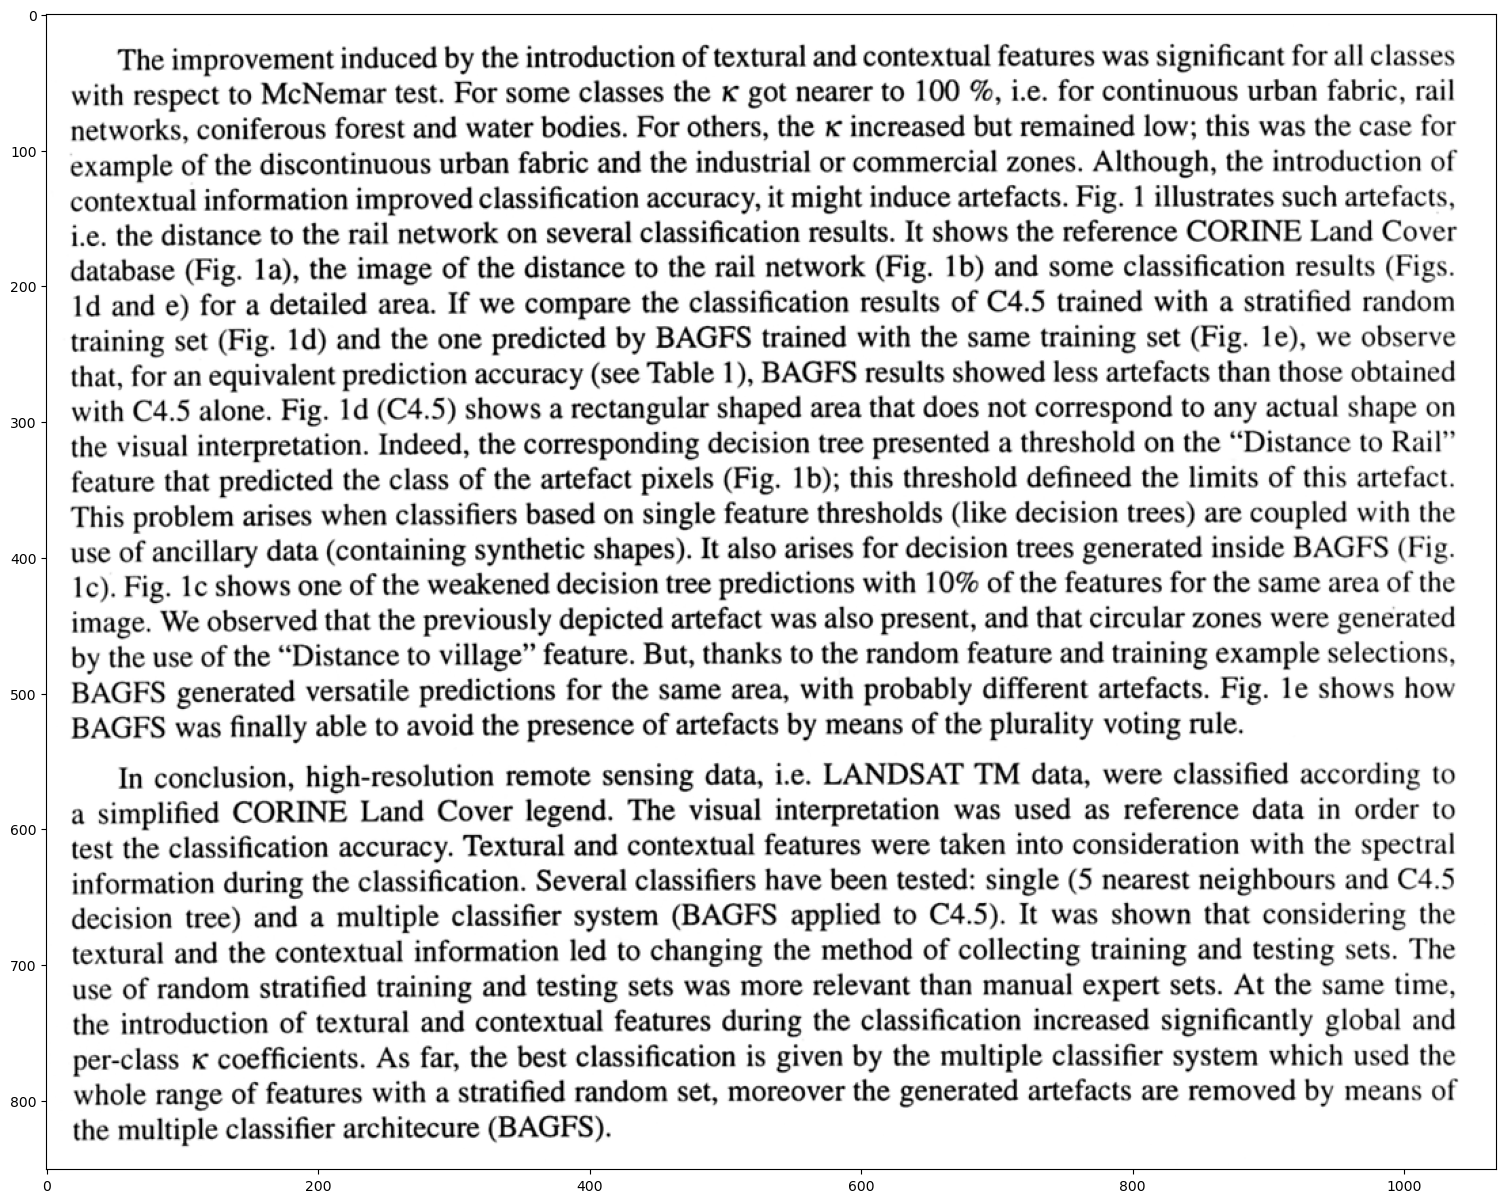

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
%matplotlib inline

im = imread('../data/doc1.png')
print(im.shape, im.dtype)

plt.figure(figsize=(20,15))
plt.imshow(im, cmap=plt.cm.gray)
plt.show()

* **Segment** the image to isolate the text from the background
* **Label individual characters** and **extract** the centroid position, the bounding box, and useful features for each character.

Useful documentation: [`skimage.measure`](http://scikit-image.org/docs/dev/api/skimage.measure.html) module.

0 255


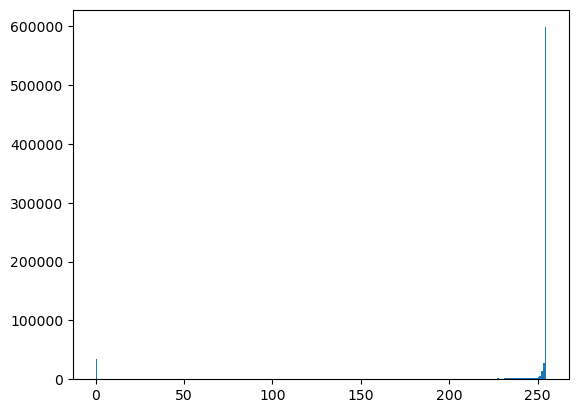

In [3]:

## -- Your code here -- ##

#separate letters from the background (binary segmentation problem), donc character class et background.

print(im.min(), im.max())
plt.hist(im.flatten(), bins = 255)
plt.show() # on voit que c'est assez facile à séparer les 2 ici

#Algo pour segmenter auto : otsu, ... mais pas très interessant ici, pcq flat entre les 2 pics, donc dur de savoir si on coupe à 100, 150, ... donc mieux de faire manuelleent



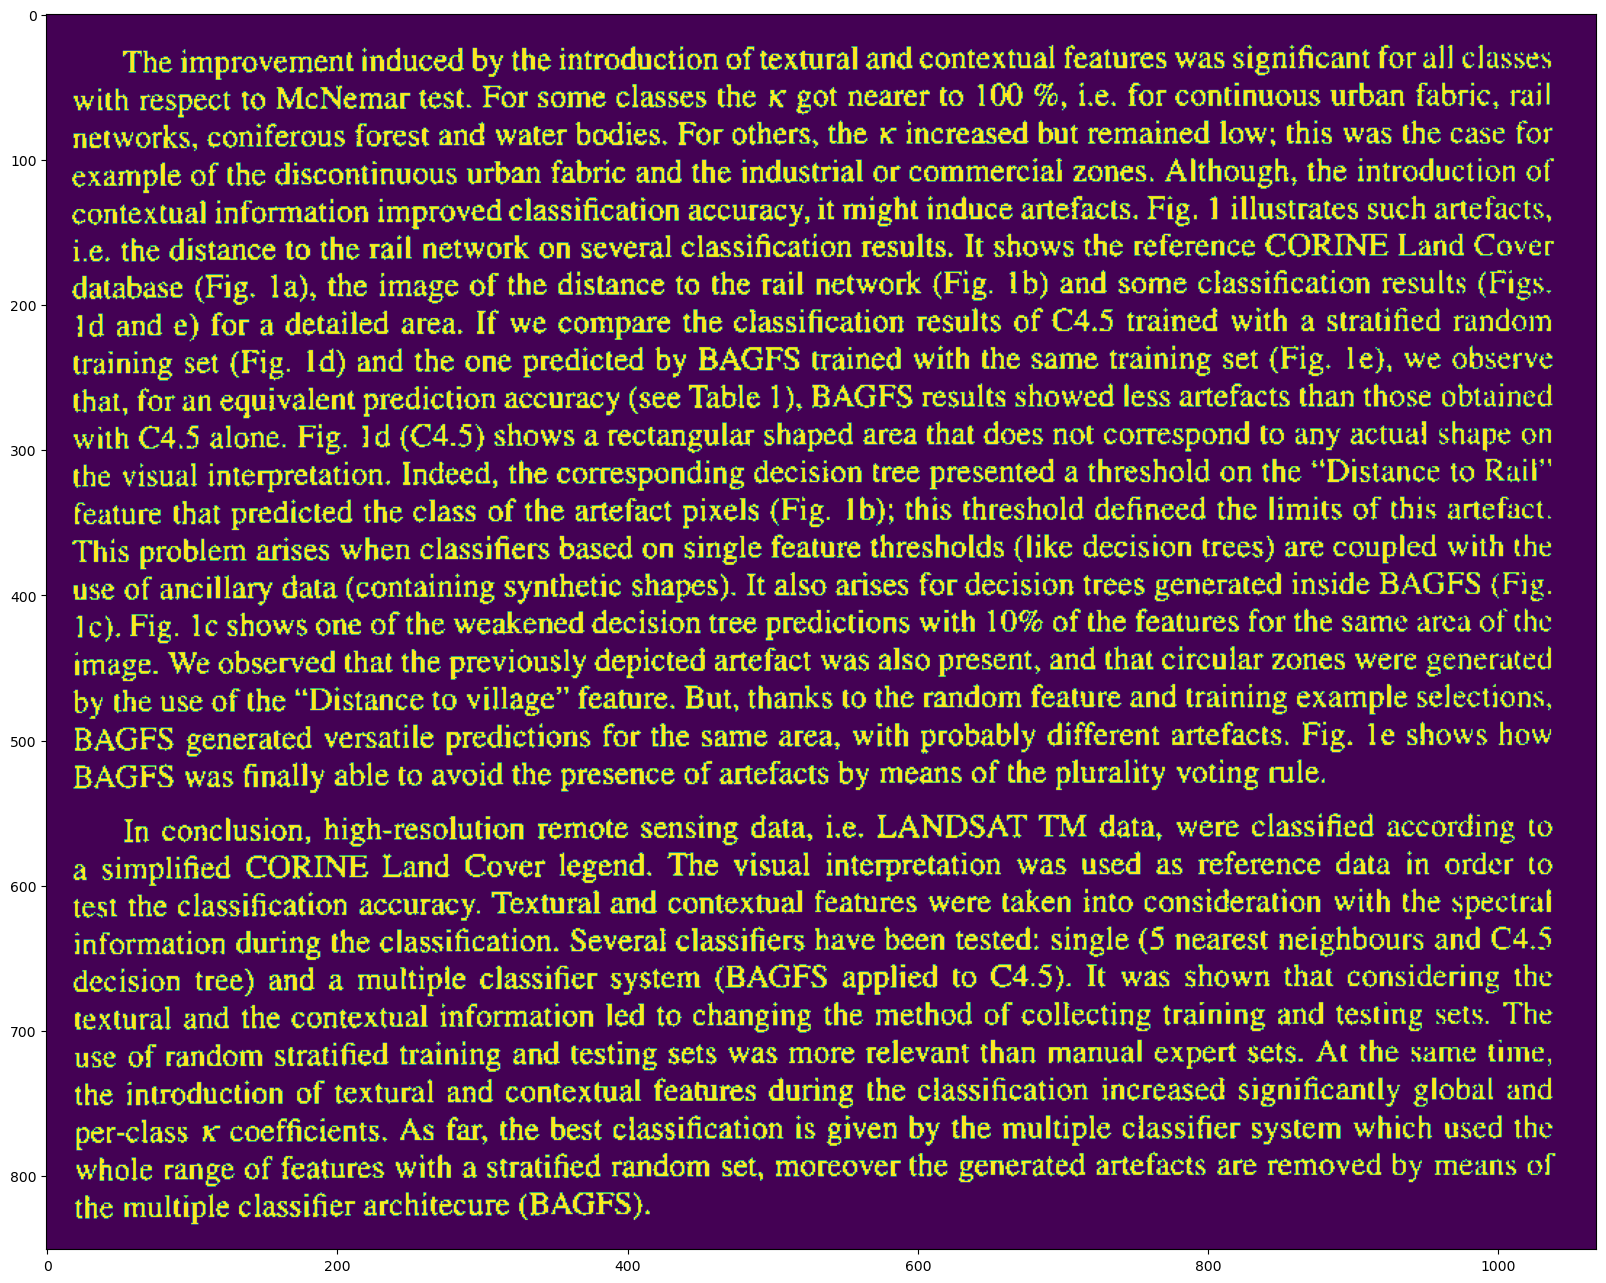

In [4]:
segmented = im < 150 # avec 127, les s sont pas très bien coupés. on check sur chacun des pixels et on get un array true false sur le pixel d'interet
plt.figure(figsize=(20,20))
plt.imshow(segmented)
plt.show()

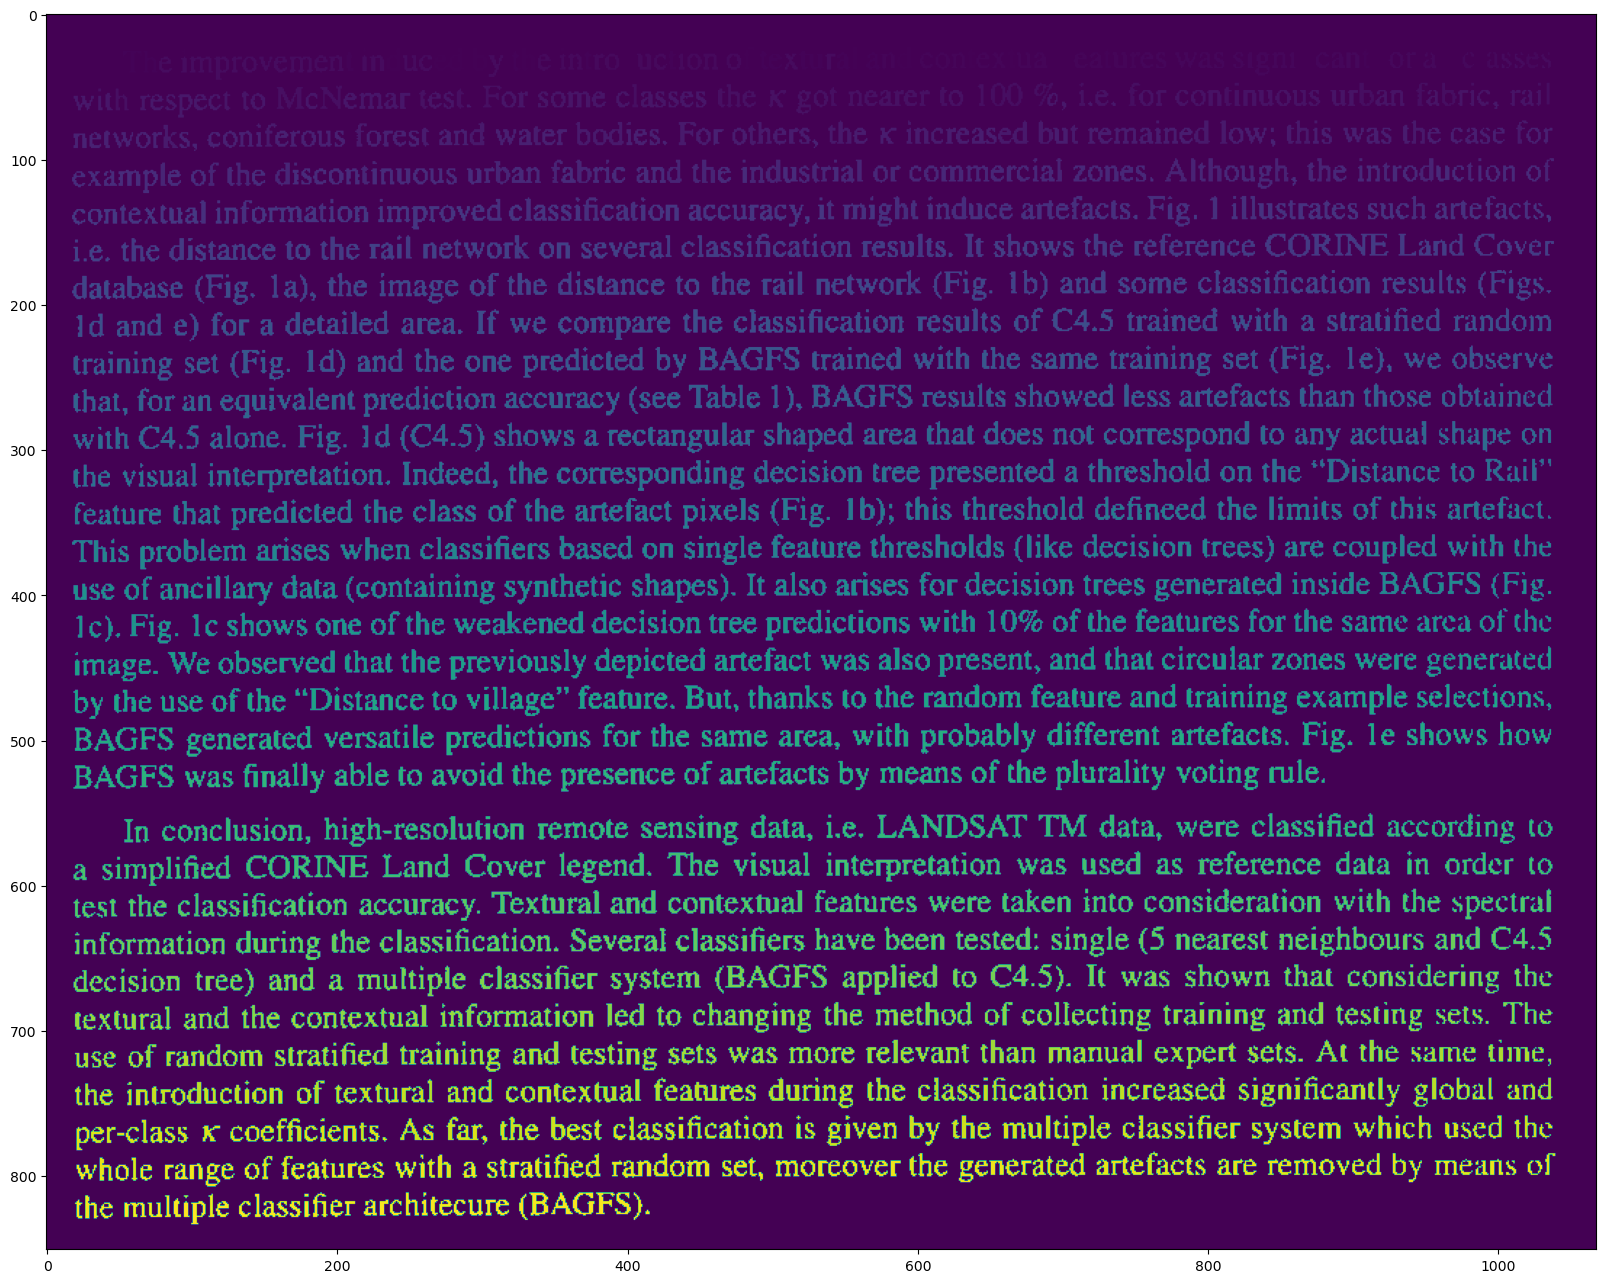

In [5]:
# Mais ici on a que séparation binaire, on veut faire instance segmentation, càd séparer chaque instance
# et idée est de dire : si les objets sont connectés, même objet 
# et pour ça on utilise skimage (voir documentation ou vidéo) : mais la connectivité peut être différente par exemple considiérer les diagonales ou pas, ... (1-conenctivity, 2 connectivty)
#Mais risque de 1 conencitvity par exemple c'est que some letters vont être connectés ensemble ou bien une lettre sera séparé en plusieurs. 
#Mais donc regarder image et choisir

from skimage.measure import label

label_image = label(segmented) # on donne un label à chaque instance, et donc les instances qui ont la même valeur sont les mêmes objets.
#pb par contre pour les i avec le point au dessus

# si on zoom sur un with : on voit que le h sera plus foncé que le w (logique) mais du coup pas fiable pour donner l'ordre 
plt.figure(figsize=(20,20))
plt.imshow(label_image) # on voit que label donné de top to bottom et de guache à droite. et higher label en bas de la page.
plt.show()

In [6]:
# Maintenant si on veut trouver l'ordre : on extrait info à propos de la position de chaque instance/caractère.
#pour ça on va regarder centroides ; les objets proches devraient avoir centroide close

from skimage.measure import regionprops # regionprops donne plein d'infos/features sur chaque label qui sera important pour ordre et aussi séparer les caractères vu qu'ils auront des stats diff
# mais d'abord classification, faut donner le bon ordre

objects_properties = regionprops(label_image)

for obj in objects_properties:
    print(obj['centroid'], obj['bbox']) # centroid et rectangle de leur bounding box (starting row, end row, starting col and end col)
    break

# Mainteant il faut utiliser ces infos pour determiner pour chaque lettre à quelle line il appartient, donc en gros mettre les lettres de la même ligne sur une ligne

(30.142857142857142, 692.5142857142857) (22, 691, 38, 695)



## Line detection and letter ordering

* Find the labels (objects) that belong to each text line
* Order each character in a text line from left to right

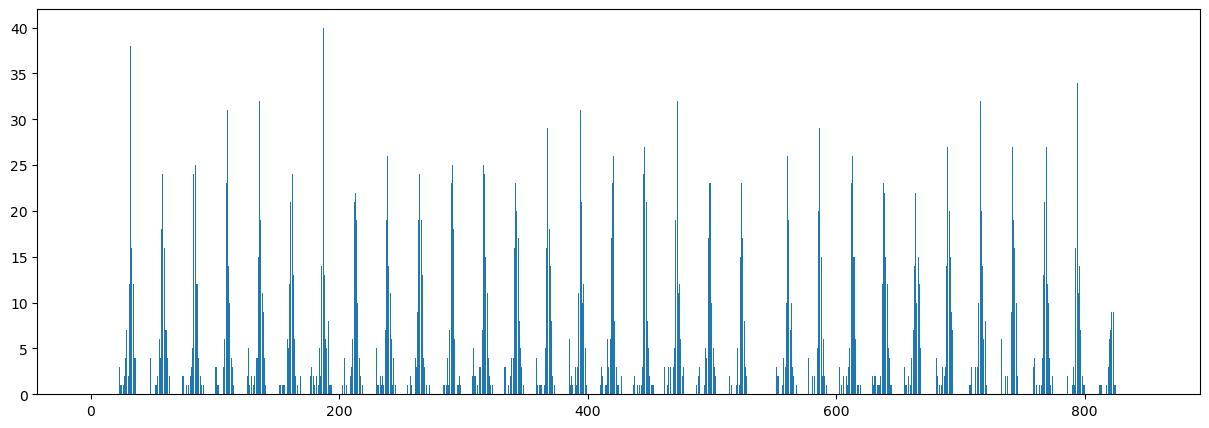

In [7]:
# Mainteant il faut utiliser ces infos pour determiner pour chaque lettre à quelle line il appartient, donc en gros mettre les lettres de la même ligne sur une ligne
# Et pour ça, on peut utiliser centroid ou bounding box
# donc on veut regrouper les lettres en fct de la ligne à laquelle elles appartiennent
centroid_ys = np.zeros((im.shape[0])) # nombre de lignes

for obj in objects_properties:
    centroid_ys[int(obj['centroid'][0])] += 1 # en gros ça donne un histo me dit pour chaque ligne, combien d'ojets j'ai où le centroid est à cette position

plt.figure(figsize=(15, 5))
plt.bar(range(im.shape[0]), centroid_ys)
plt.show()

In [ ]:
# Pb discontuinité  ! réecouter si jamais vers 35min
# lignes pas tout à fait horizontal : end surement plus haut que le début d'une ligne
# et d'autres trucs

# donc ce qu'on peut faire : si area en dessous d'un certain seuil, we don't count it ! (genre enlelver les points des i)

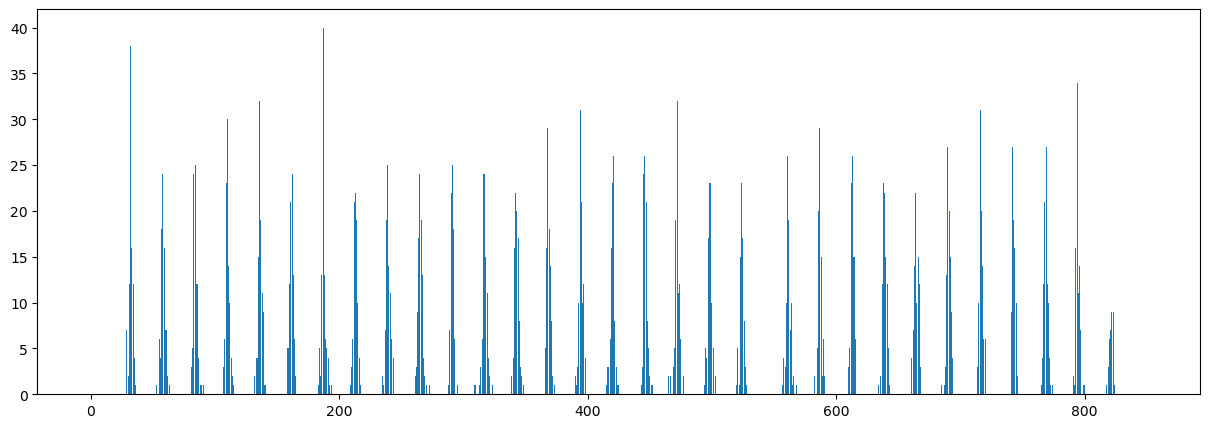

In [8]:
centroid_ys = np.zeros((im.shape[0])) # nombre de lignes

for obj in objects_properties:
    if obj.area < 10 : # filter smaller than 10 pixels, donc on enleve les artefeact
        continue
    centroid_ys[int(obj['centroid'][0])] += 1 
plt.figure(figsize=(15, 5))
plt.bar(range(im.shape[0]), centroid_ys)
plt.show()

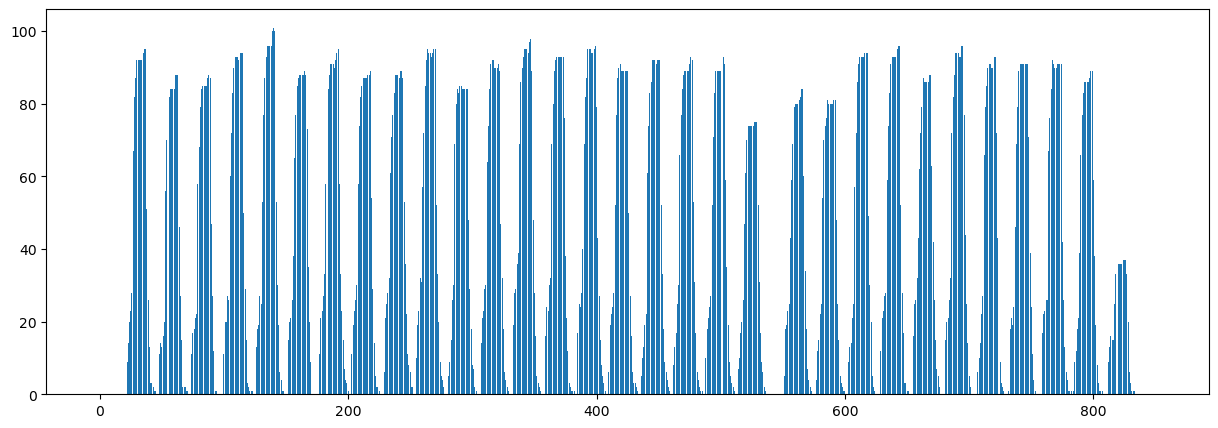

In [9]:
bbox_ys = np.zeros((im.shape[0])) # nombre de lignes

for obj in objects_properties:
    bbox_ys[obj["bbox"][0]:obj['bbox'][2]] += 1 

plt.figure(figsize=(15, 5))
plt.bar(range(im.shape[0]), bbox_ys)
plt.show()

#Et pour trouver les lignes (rows), on peut prendre les max de chaque mini stribution, et ça serati bon guess pour trouver les lignes du texte
#et donc on peut trouver la position de chaque pic, et assigner à chaque objet, asigner un pic et dire que l'objet appartient à cette ligne
#on pourrait aussi se dire : dès que j'ai pas de centroid pdt 4 valeurs, je peux cut et me dire ce qu'il y avait avant fait partie d'une ligne

In [ ]:
# aussi assez discontinue entre chaque pic

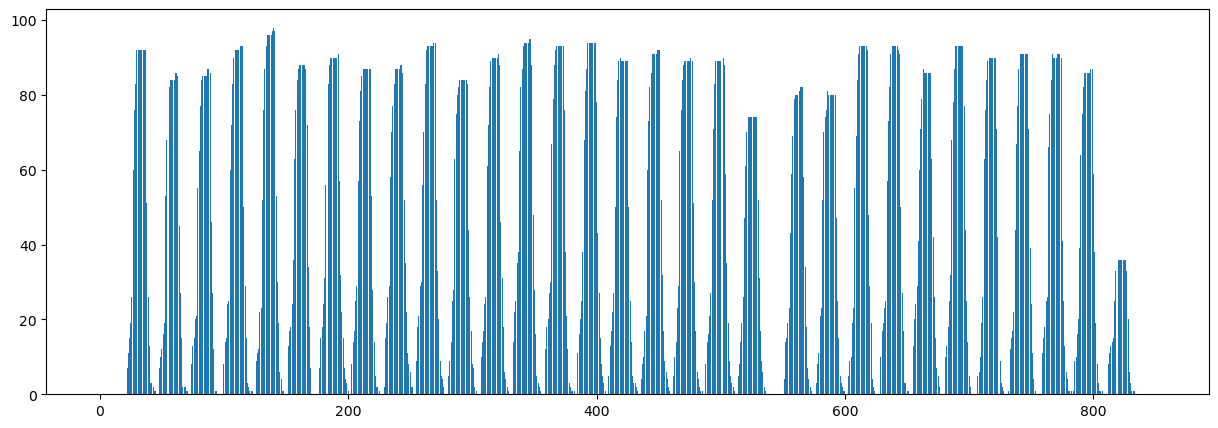

In [10]:
bbox_ys = np.zeros((im.shape[0])) # nombre de lignes

for obj in objects_properties:
    if obj.area < 10 : # filter smaller than 10 pixels, donc on enleve les artefeact
        continue
    bbox_ys[obj["bbox"][0]:obj['bbox'][2]] += 1 

plt.figure(figsize=(15, 5))
plt.bar(range(im.shape[0]), bbox_ys)
plt.show()



In [ ]:
# Solution proposée avec centroid approach (voir vidéo à genre 45min)

#il donne aussi d'autres méthodes

# Il a dit ausis qu'il y avait une méthode peak local max de skimmage pour chooper les mins/max



[32, 58, 84, 110, 136, 162, 187, 213, 239, 265, 291, 316, 342, 368, 394, 421, 446, 472, 498, 524, 561, 587, 613, 638, 664, 690, 716, 742, 769, 794, 822]


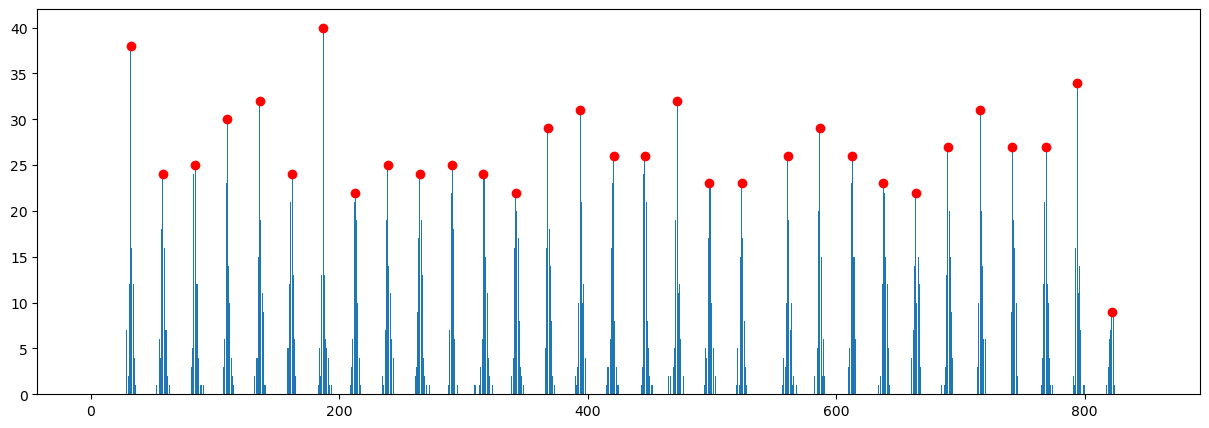

In [25]:
centroid_ys = np.zeros((im.shape[0]))
for obj in objects_properties:
    if obj.area < 10:
        continue
    centroid_ys[int(obj['centroid'][0])] += 1

maxima = []
for y in range(3, im.shape[0]-3):
    if centroid_ys[y] == centroid_ys[y-3:y+3].max() and centroid_ys[y] > 5 and (y-1 not in maxima):
        maxima.append(y)

print(maxima)

plt.figure(figsize=(15,5))
plt.bar(range(im.shape[0]), centroid_ys)
for m in maxima:
    plt.plot(m, centroid_ys[m], 'ro')
plt.show()


Axe x : Ce sont les positions verticales dans l'image (les hauteurs y)

Axe y : the number of letters having their centroid at this height

Then we can take max local to find lines

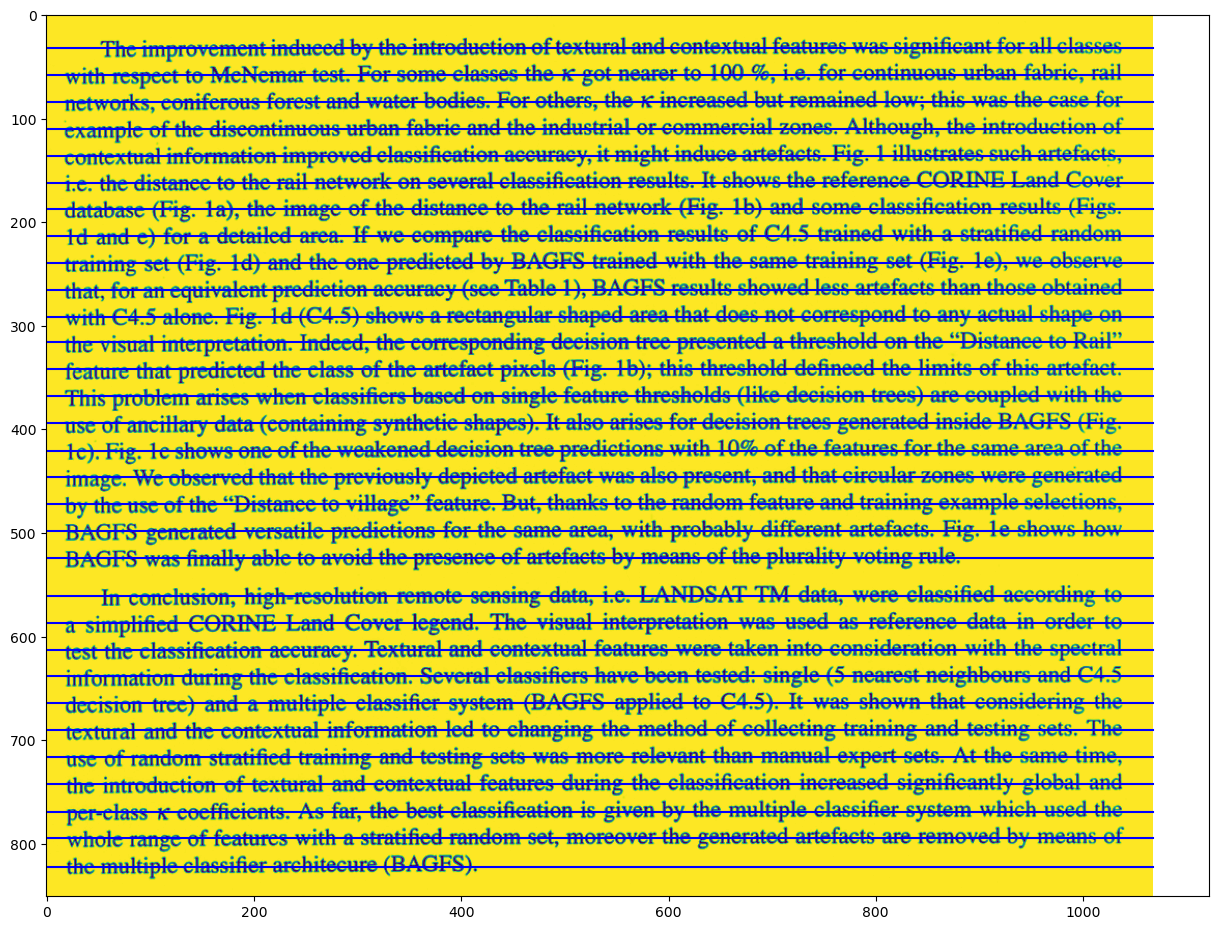

In [26]:
plt.figure(figsize=(15,15))
plt.imshow(im)

for m in maxima:
    plt.plot([0, im.shape[1]], [m, m], 'b-')

plt.show()


## Ordering

Here we assign each letter to each line

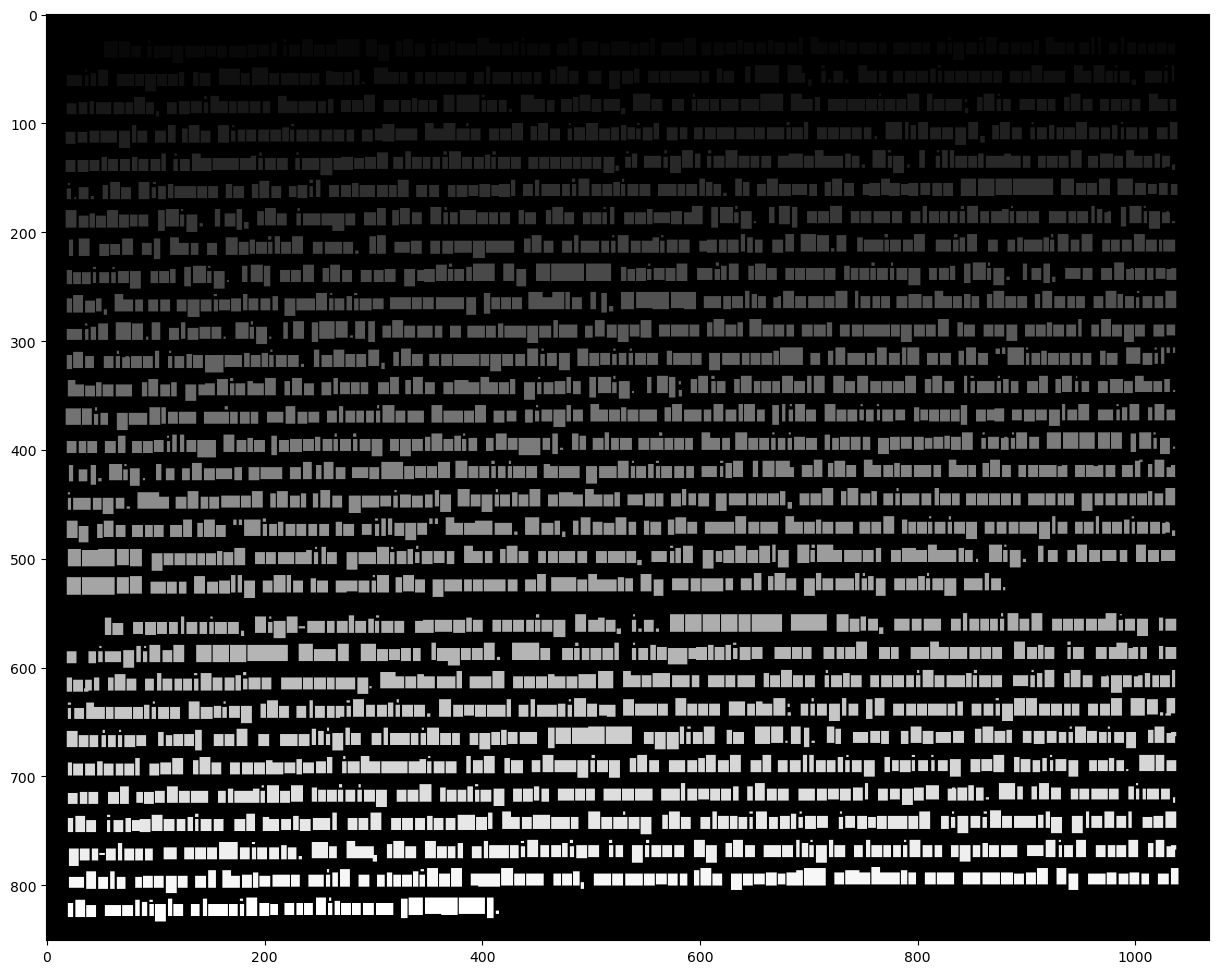

In [27]:
label_to_line = [[] for _ in range(len(maxima))]
maxima = np.array(maxima)
plt.figure(figsize=(15,15))
im_lines = np.zeros(im.shape)

for obj in objects_properties:
    closest_line = np.abs(obj.centroid[0] - maxima).argmin()
    label_to_line[closest_line].append(obj)
    im_lines[obj.bbox[0]:obj.bbox[2], obj.bbox[1]:obj.bbox[3]] = closest_line + 1

plt.imshow(im_lines, cmap=plt.cm.gray)
plt.show()


We order the letter for each line

In [28]:
ordered_labels = [[] for _ in range(len(maxima))]

for i, line_objects in enumerate(label_to_line):
    x_pos = np.array([obj.centroid[1] for obj in line_objects])
    x_order = x_pos.argsort()

    for x in x_order:
        ordered_labels[i].append(line_objects[x])


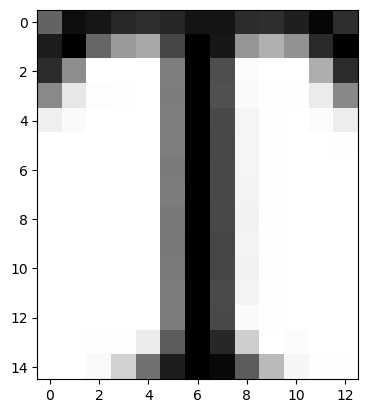

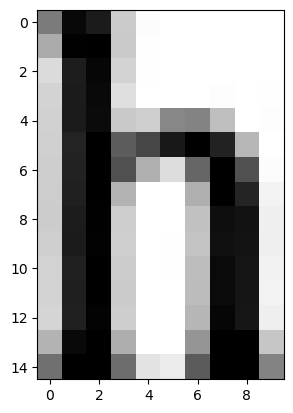

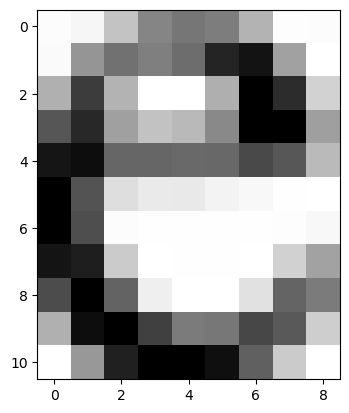

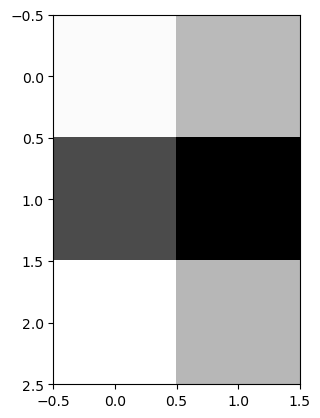

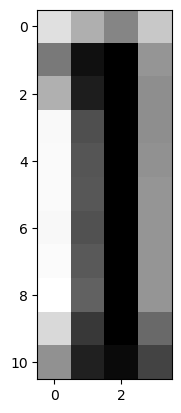

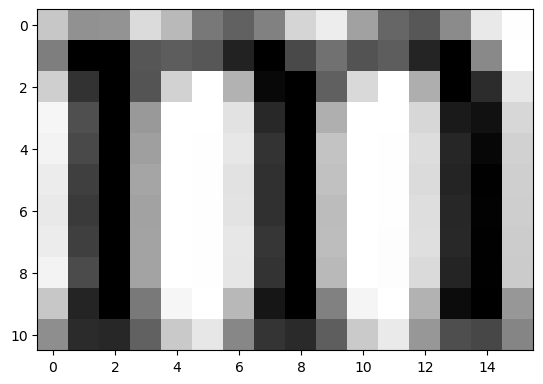

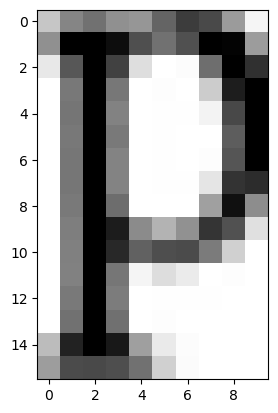

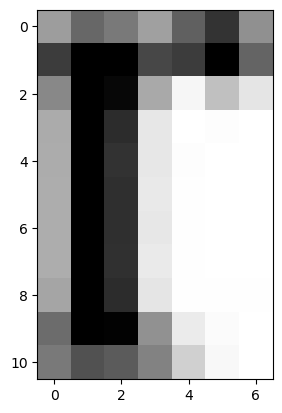

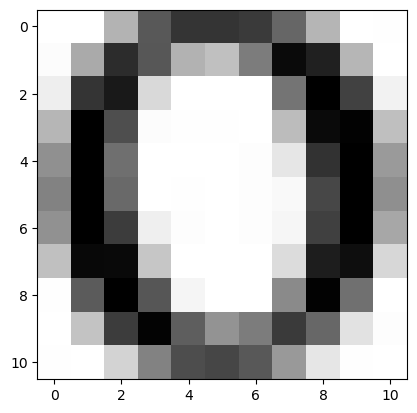

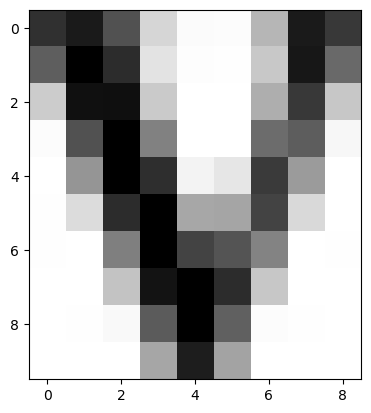

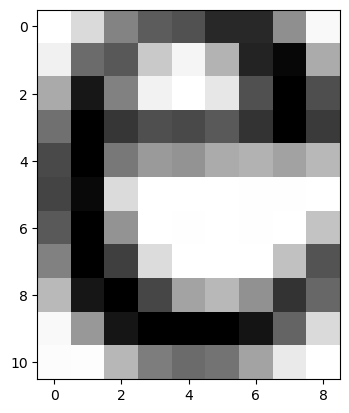

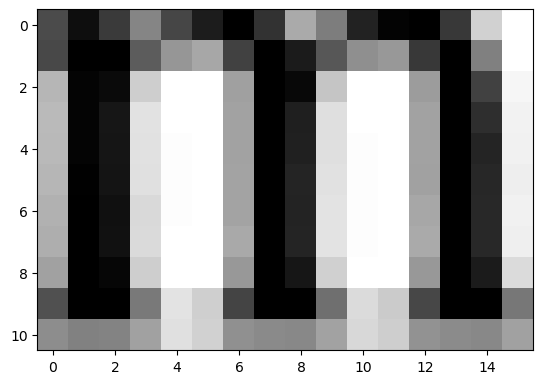

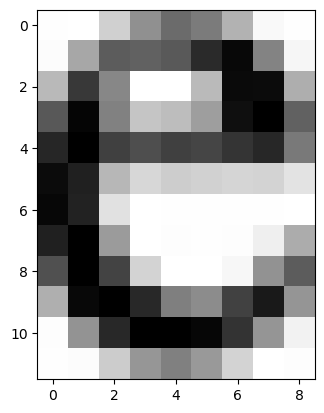

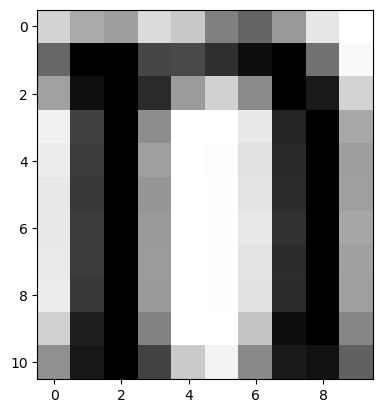

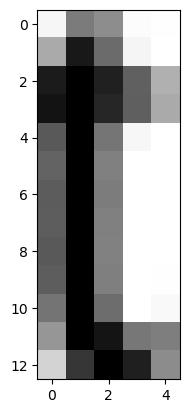

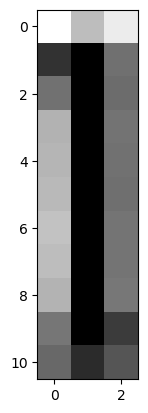

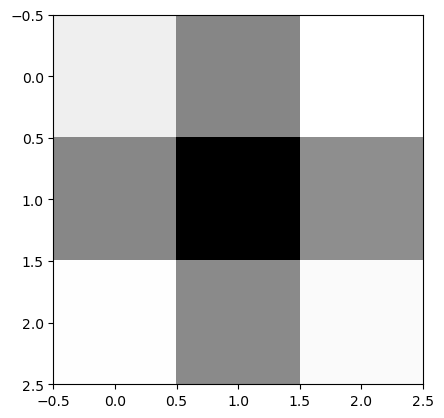

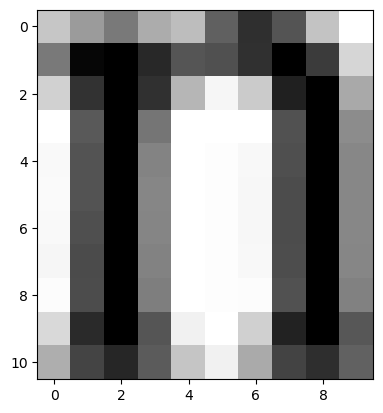

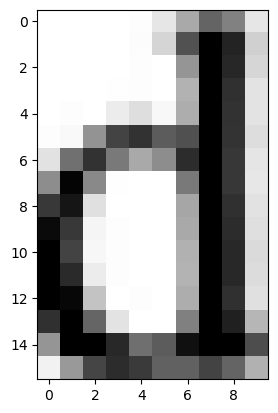

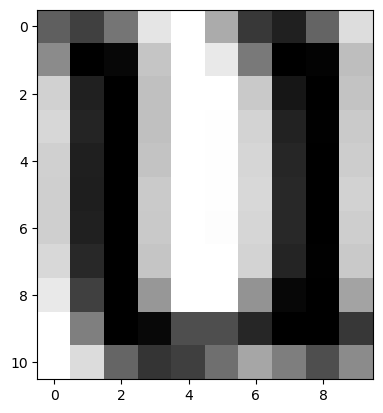

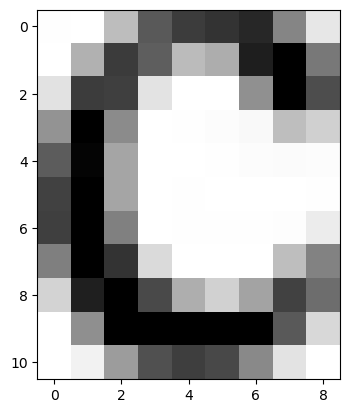

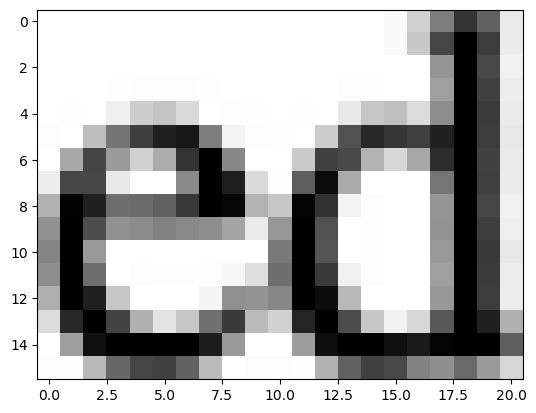

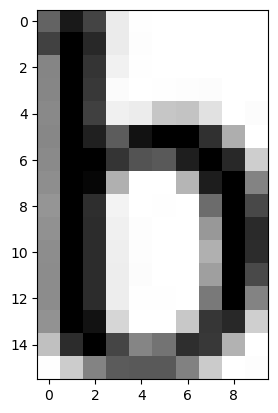

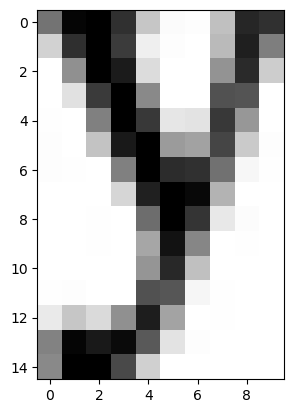

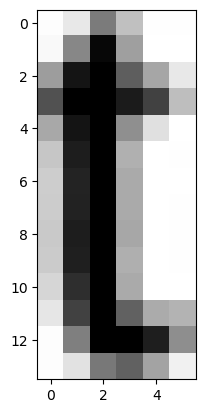

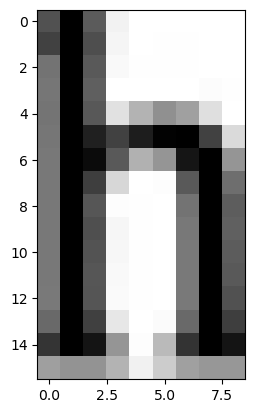

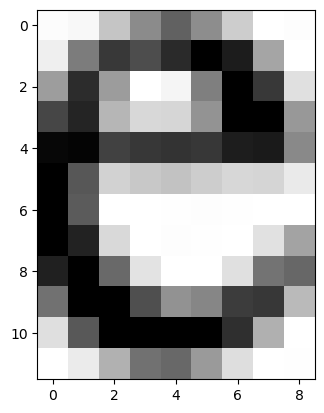

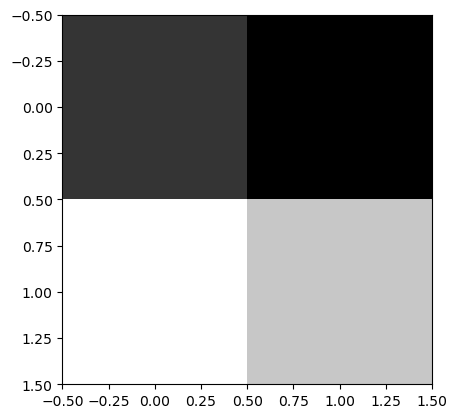

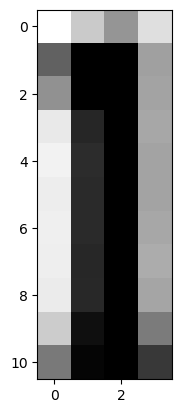

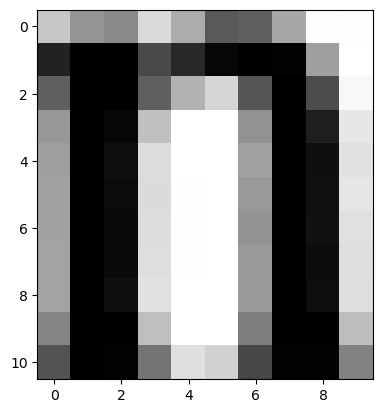

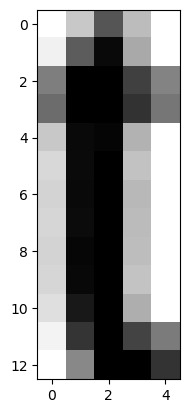

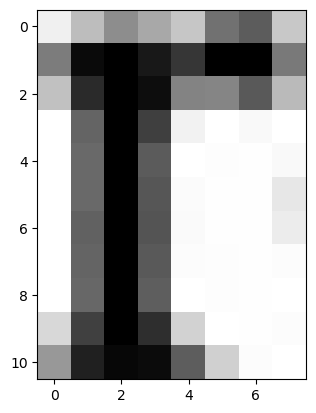

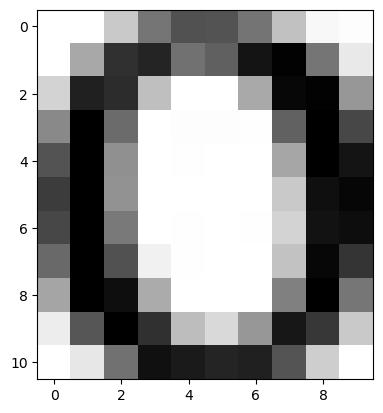

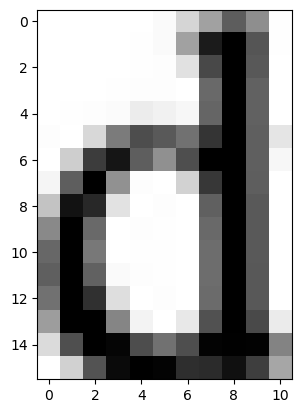

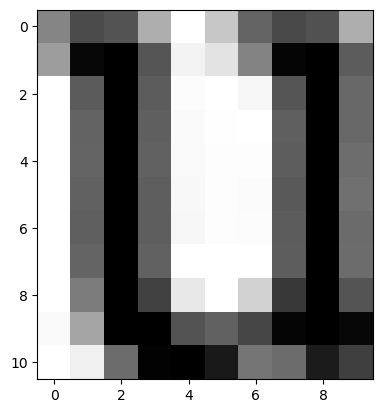

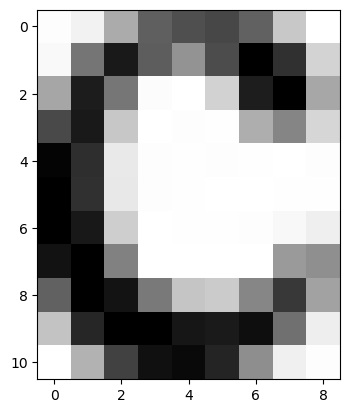

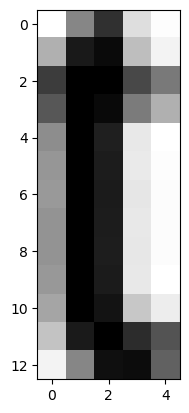

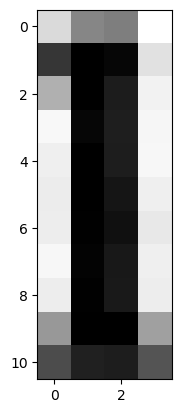

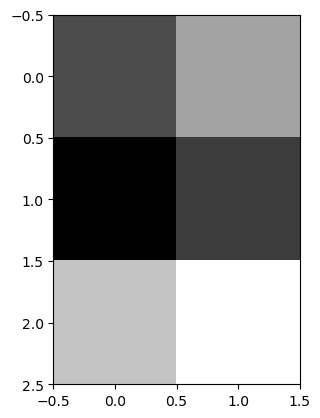

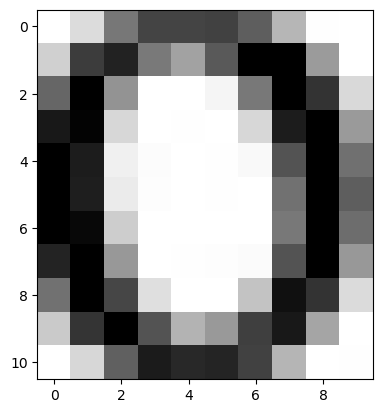

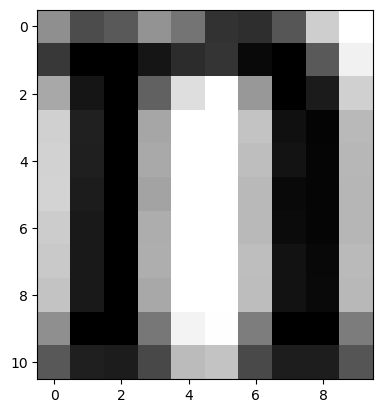

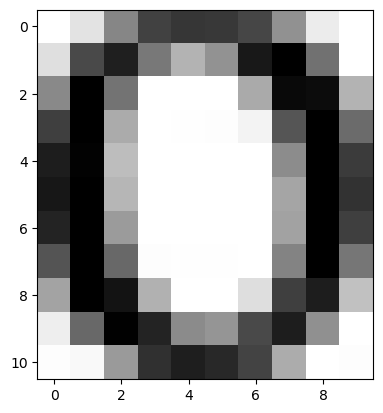

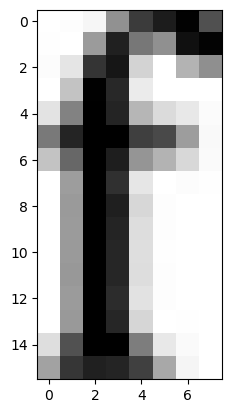

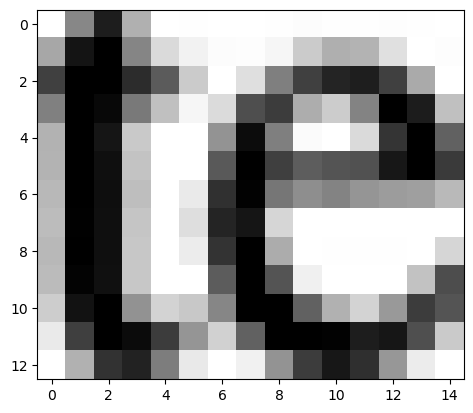

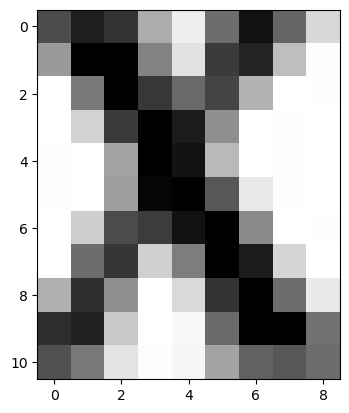

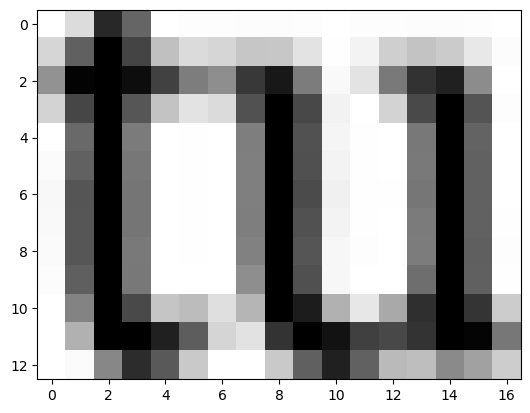

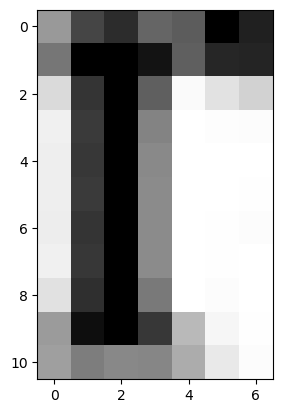

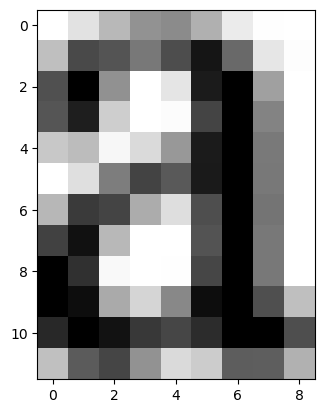

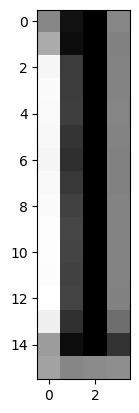

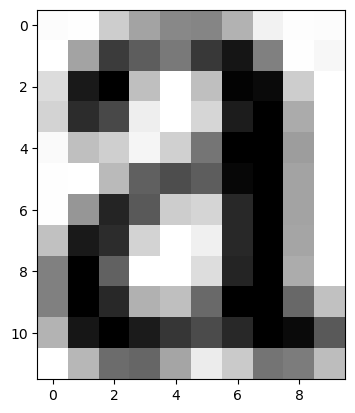

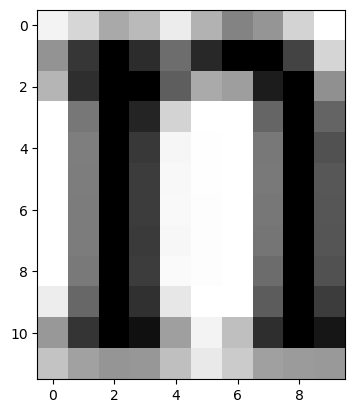

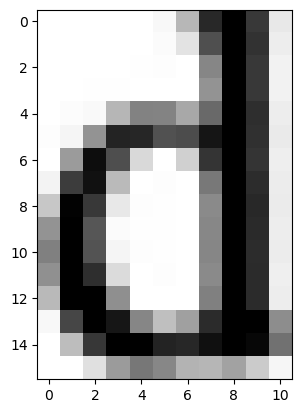

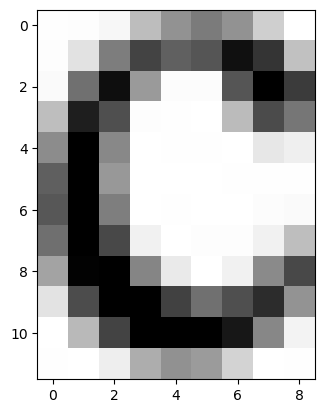

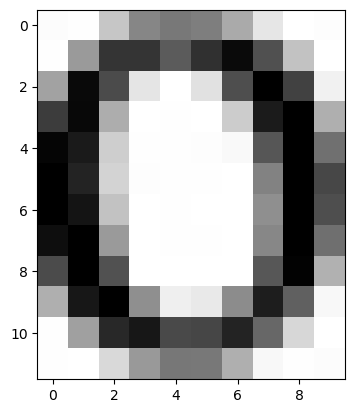

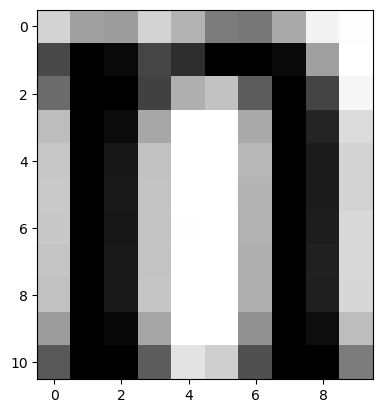

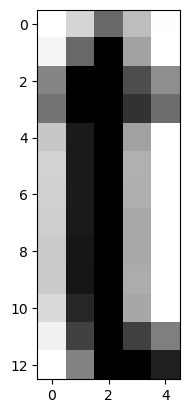

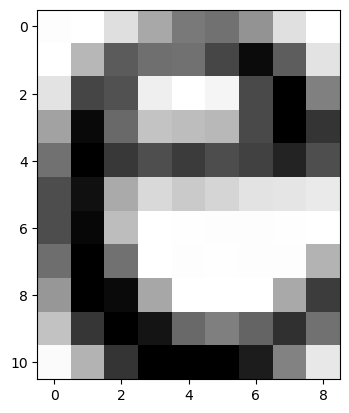

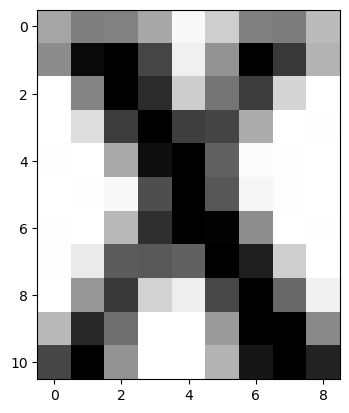

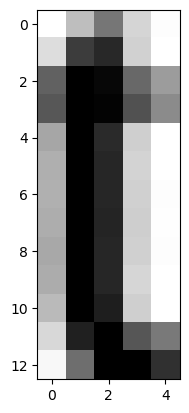

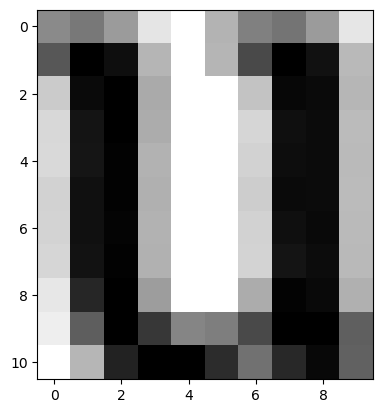

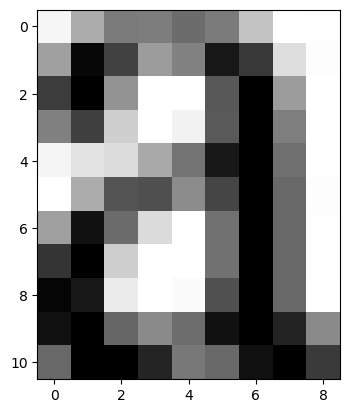

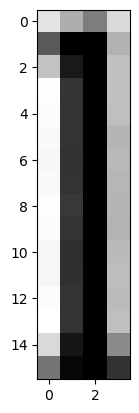

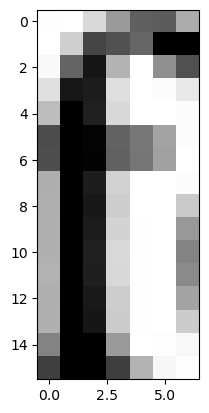

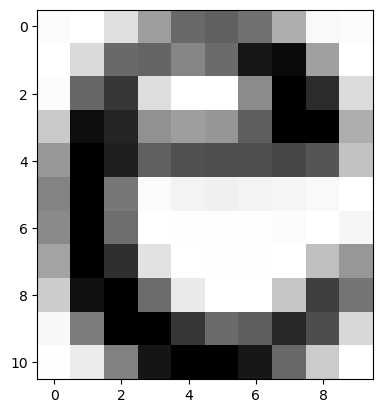

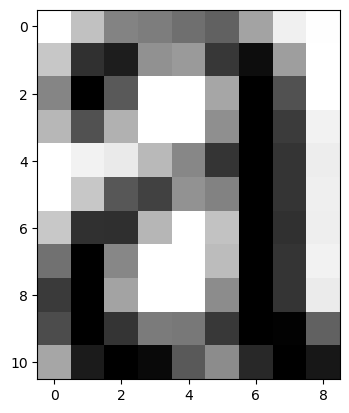

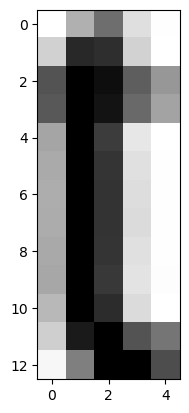

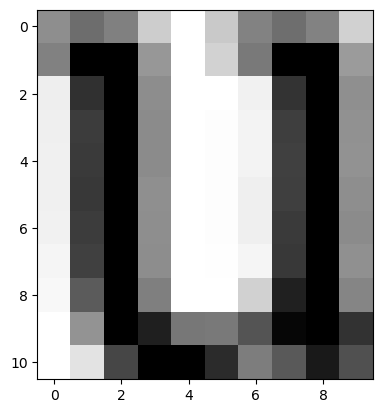

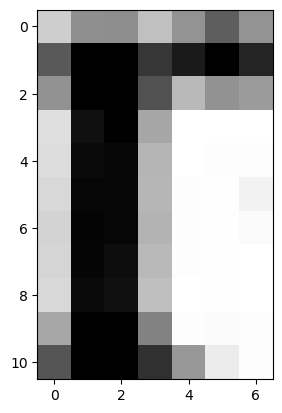

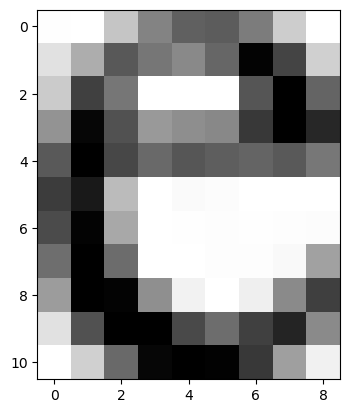

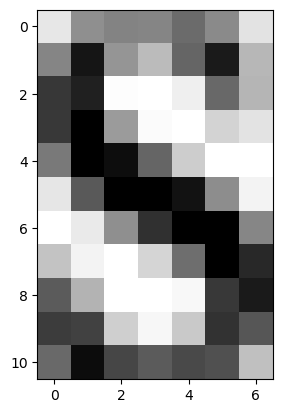

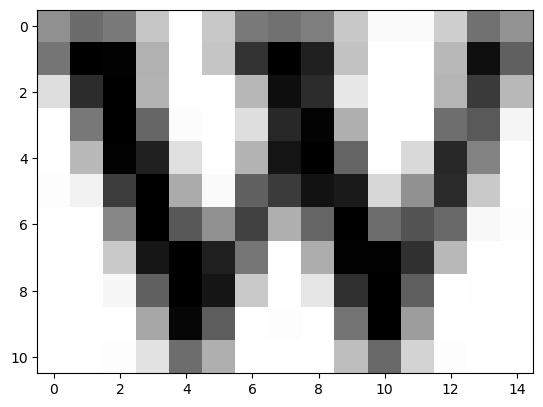

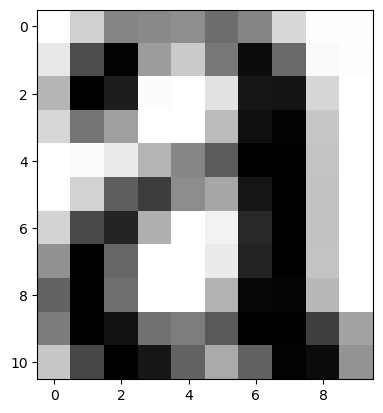

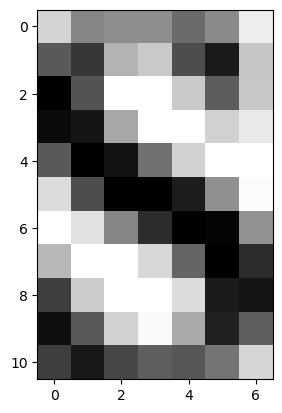

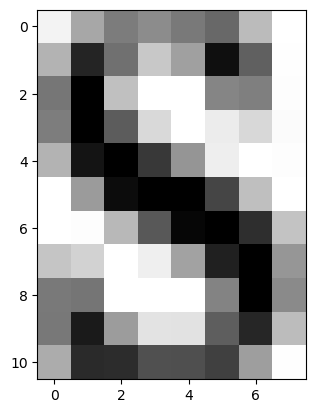

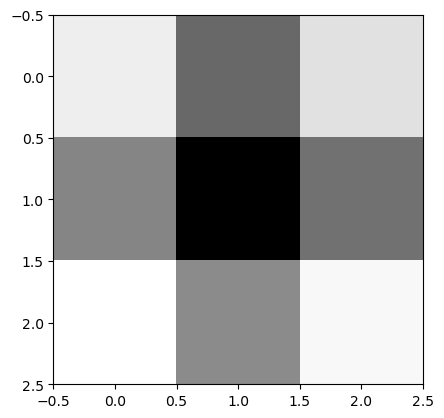

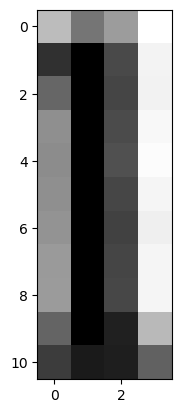

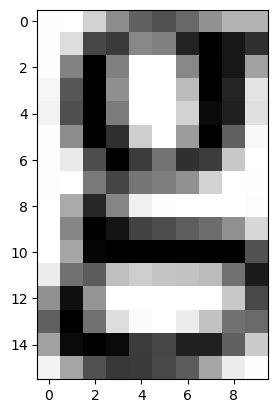

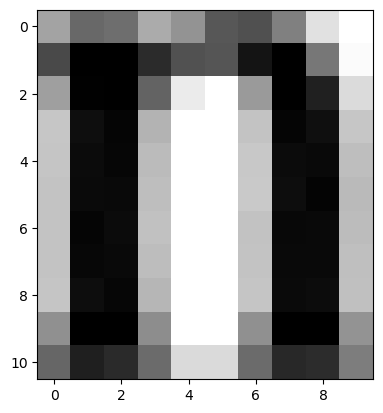

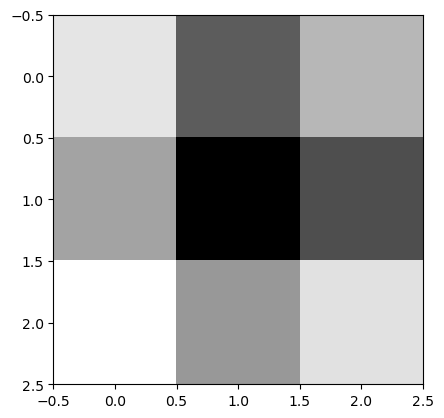

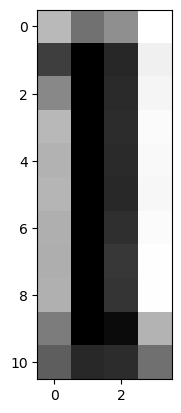

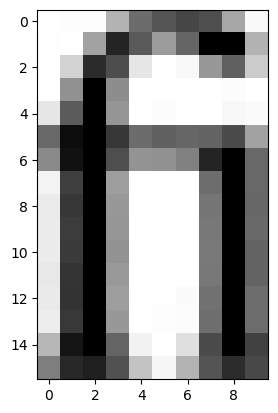

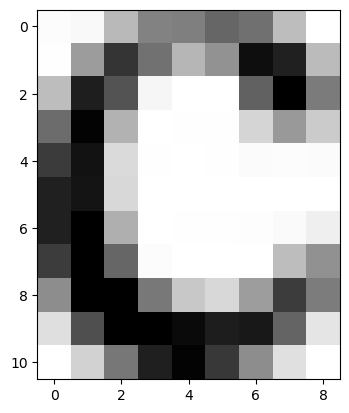

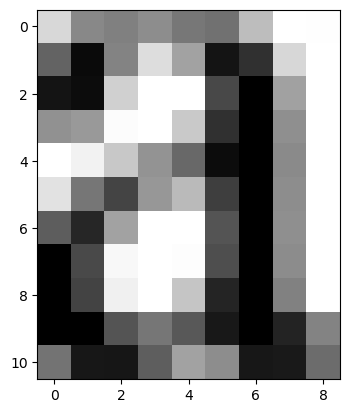

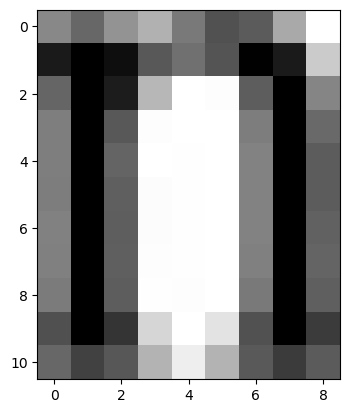

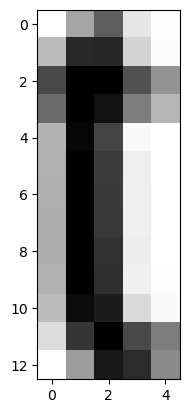

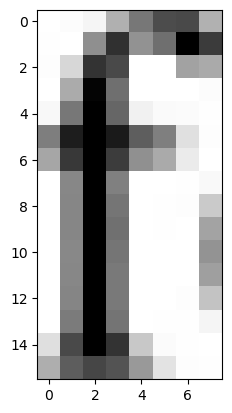

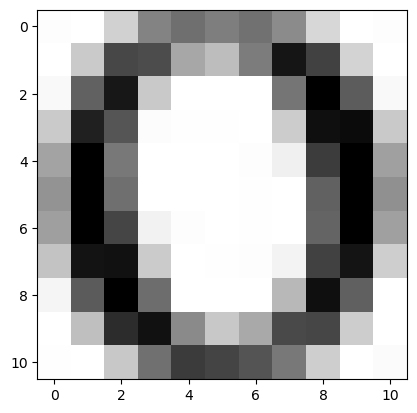

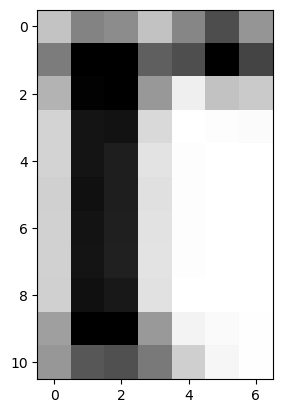

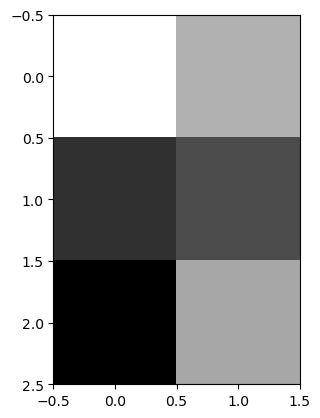

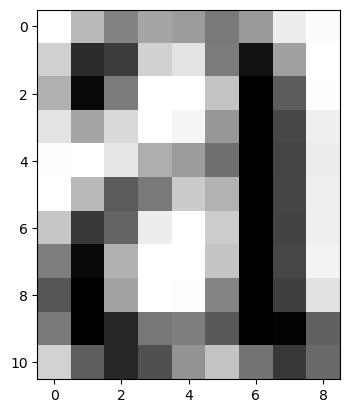

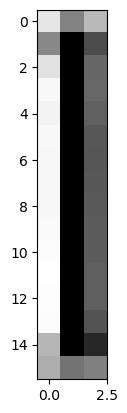

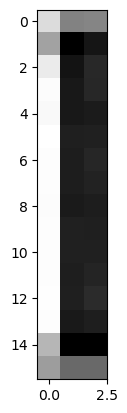

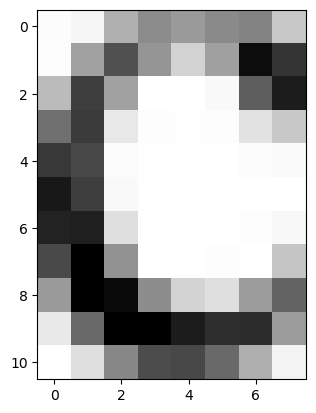

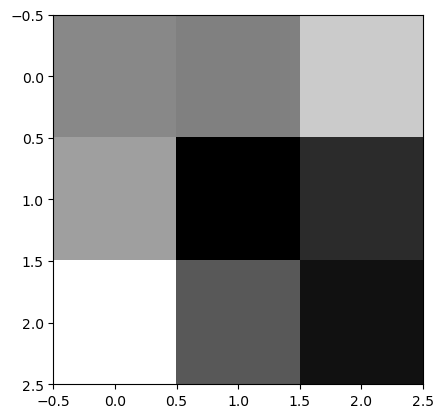

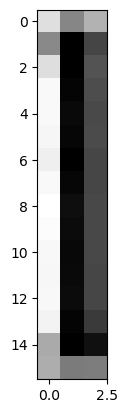

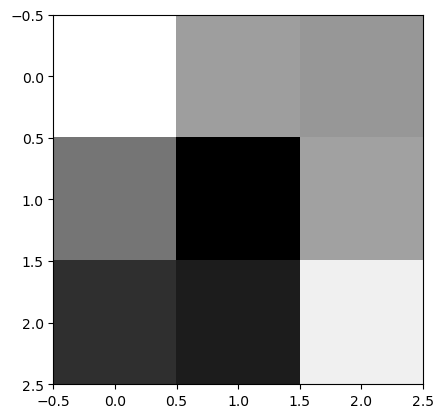

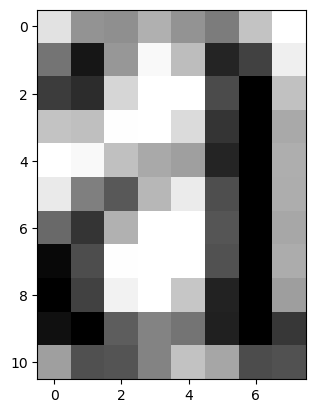

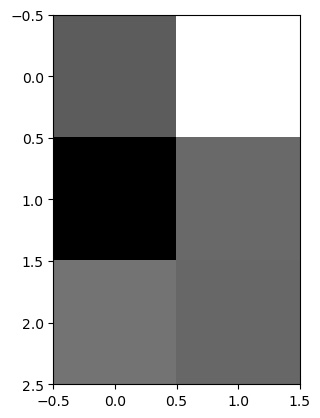

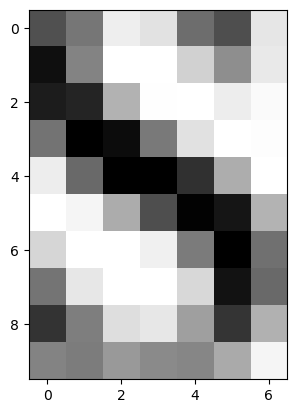

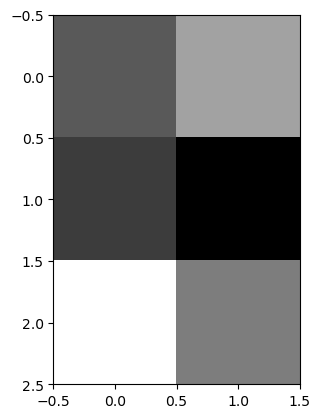

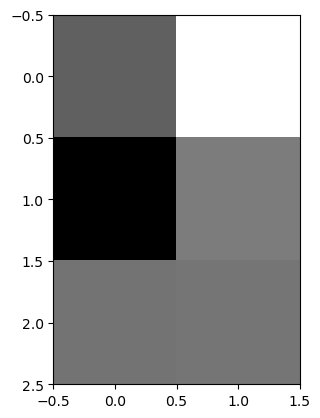

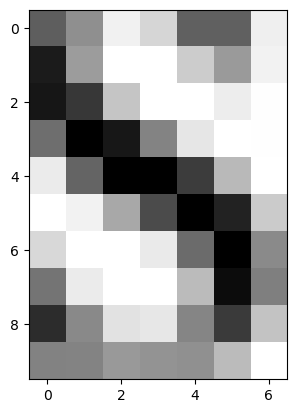

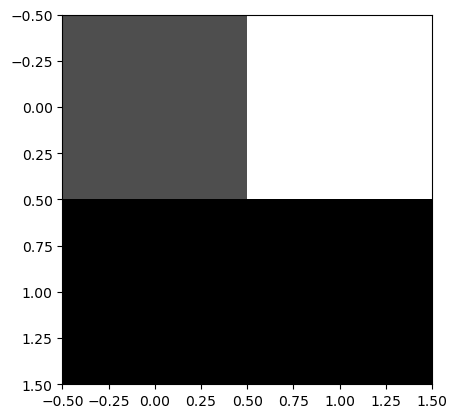

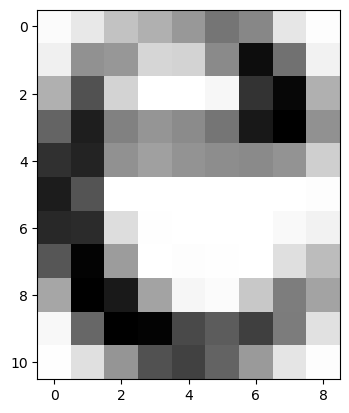

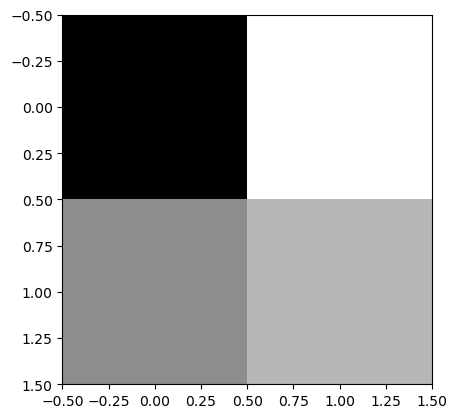

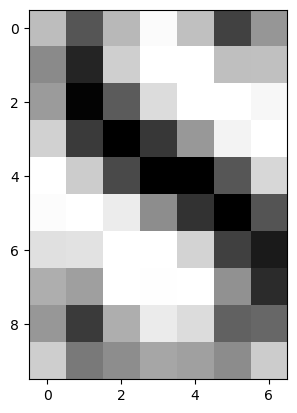

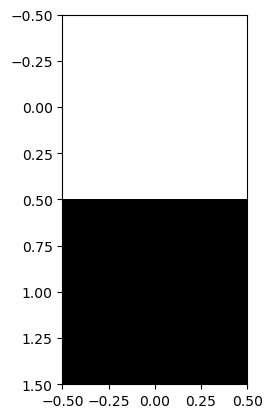

In [29]:
for obj in ordered_labels[0]:
    plt.figure()
    plt.imshow(im[obj.bbox[0]:obj.bbox[2], obj.bbox[1]:obj.bbox[3]], cmap=plt.cm.gray)
    plt.show()


## Expert System classification

* Using the features available with the [regionprops](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) method of scikit-image, propose a method to automatically recognize some letters.

 The idea here is:
You don’t need to train a full machine learning model yet.

You create hand-crafted rules based on features like:

area

eccentricity

extent

aspect_ratio (computed from bounding box)

solidity, etc.

In [12]:
# Expert system classification based on regionprops features

for obj in objects_properties:
    area = obj.area
    bbox = obj.bbox
    width = bbox[3] - bbox[1]
    height = bbox[2] - bbox[0]
    
    if height == 0:  # avoid division by zero
        continue

    aspect_ratio = width / height
    eccentricity = obj.eccentricity
    extent = obj.extent
    solidity = obj.solidity

    # simple rule-based classification (corrected version)
    if area < 20:
        letter = '.'  # tiny objects -> probably dot
    elif aspect_ratio < 0.2:
        letter = 'I'  # very tall and thin
    elif 0.8 <= aspect_ratio <= 1.2 and extent > 0.7 and eccentricity < 0.6:
        letter = 'O'  # roughly circular shapes
    elif aspect_ratio < 0.15 and height > 3 * width:
        letter = 'l'  # very thin and tall (possibly "l")
    else:
        letter = '?'  # unknown / unclassified

    print(f"Object at {obj.centroid}: classified as '{letter}'")



Object at (30.142857142857142, 692.5142857142857): classified as '?'
Object at (29.043478260869566, 704.1521739130435): classified as '?'
Object at (23.0, 829.0): classified as '.'
Object at (23.0, 858.0): classified as '.'
Object at (29.976744186046513, 867.7441860465116): classified as '?'
Object at (29.150943396226417, 920.5849056603773): classified as '?'
Object at (29.714285714285715, 961.3714285714286): classified as 'I'
Object at (29.529411764705884, 967.4117647058823): classified as 'I'
Object at (29.714285714285715, 988.3714285714286): classified as 'I'
Object at (31.920454545454547, 401.60227272727275): classified as '?'
Object at (23.8, 437.4): classified as '.'
Object at (29.78, 483.06): classified as '?'
Object at (30.346938775510203, 556.9591836734694): classified as '?'
Object at (31.373493975903614, 591.710843373494): classified as '?'
Object at (25.0, 219.0): classified as '.'
Object at (32.86666666666667, 239.82666666666665): classified as '?'
Object at (33.1679389312

## Full OCR pipeline

Using all the previous exercices, create a method that takes as input a text image, and outputs the recognized text.

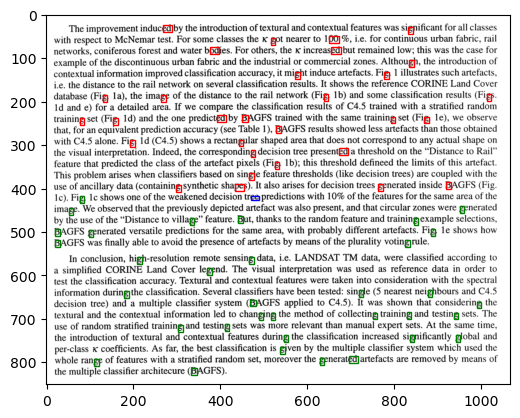

In [15]:
import numpy as np
from skimage.io import imread
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Assume your image is already loaded in 'im'
# im = imread('my_image.png')

# Simple binarization
threshold = 150
segmented = im < threshold

# Label connected components
label_image = label(segmented)
objects_properties = regionprops(label_image)

plt.figure()
plt.imshow(im, cmap=plt.cm.gray)

for obj in objects_properties:
    bbox = obj.bbox
    if obj.euler_number == -1:
        # If centroid is below image middle → classify as 'g'
        if obj.centroid[0] > im.shape[0] / 2:
            plt.gca().add_patch(Rectangle((bbox[1], bbox[0]),
                                           bbox[3] - bbox[1],
                                           bbox[2] - bbox[0],
                                           linewidth=1, edgecolor='g', facecolor='none'))
        # If bounding box height is small → classify as 'B'
        elif bbox[2] - bbox[0] < 15:
            plt.gca().add_patch(Rectangle((bbox[1], bbox[0]),
                                           bbox[3] - bbox[1],
                                           bbox[2] - bbox[0],
                                           linewidth=1, edgecolor='b', facecolor='none'))
        # Otherwise → mark as unknown (double contours etc.)
        else:
            plt.gca().add_patch(Rectangle((bbox[1], bbox[0]),
                                           bbox[3] - bbox[1],
                                           bbox[2] - bbox[0],
                                           linewidth=1, edgecolor='r', facecolor='none'))
    else:
        # Only processing Euler Number == -1 objects for now
        pass

plt.show()


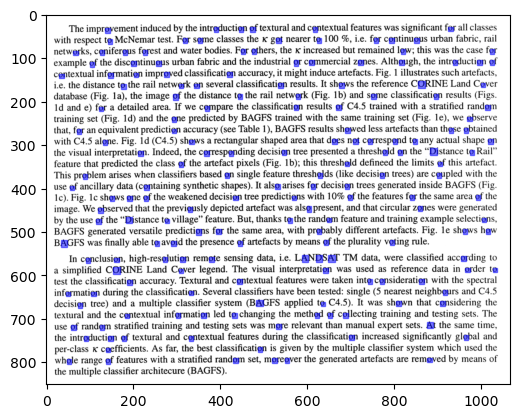

In [19]:
plt.figure()
plt.imshow(im, cmap=plt.cm.gray)

for obj in objects_properties:
    bbox = obj.bbox

    if obj.euler_number == 0 and obj.eccentricity < 0.5:
        plt.gca().add_patch(Rectangle((bbox[1], bbox[0]),
                                       bbox[3]-bbox[1], bbox[2]-bbox[0],
                                       alpha=0.5, color='blue'))

plt.show()



*******o***********g*********o*****o*o***********o*******l*************g********o**ll*l*****
*l**********o************o**o***l********go*******o*g******o**o*****o**********l****ll
****o***l*o*****o***o*************g****o*o**************g***********o*l***************o*
*******o********o*****o***************************o**o*********o*******o*g*********o****lo*o*
*o***********o****o*****o**************o**************g******************g***l*******************l
l************o***********o**o*******l*l********o************o***************o*******o***
***********g**********g*o************o***********o*****g*******o************lo*****l*****g*
********o******************o*****************o********o*****************************ol*
***l*l*g*****lg*********o*********g**g***************************l*g*****lgl**l**o*******
****l*o*********l***********o***************l****g*******l****o*********************o**o***l***
********lo****g*********o********g******************o***o**o***o***o**************o

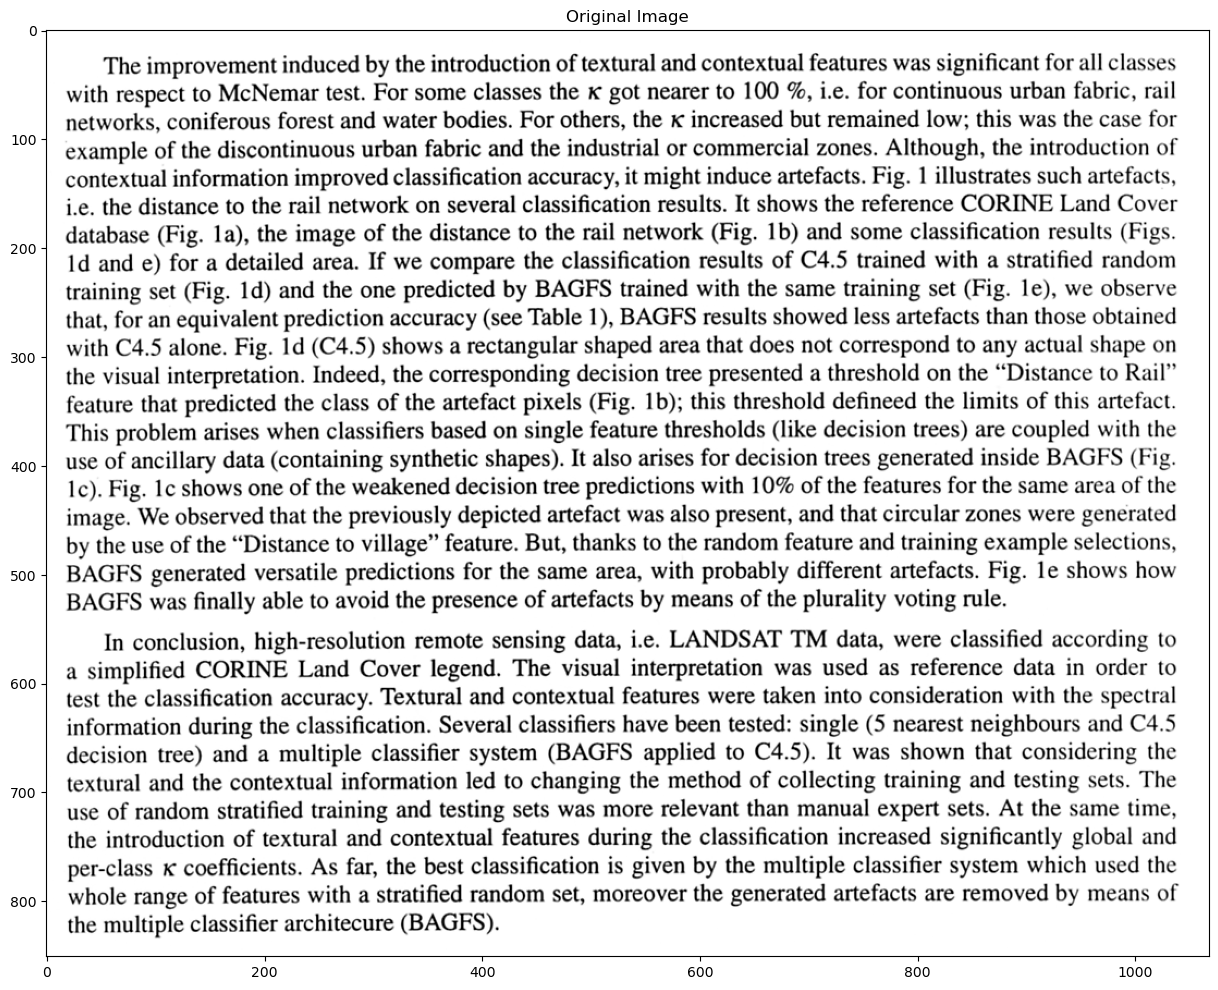

In [32]:
import numpy as np
from skimage.io import imread
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

# Step 1: Binarization & segmentation
def get_letters(im):
    threshold = 150
    segmented = im < threshold
    label_image = label(segmented)
    letters = regionprops(label_image)
    return letters

# Step 2: Line detection using maxima
def get_maxima(im, letters):
    centroid_ys = np.zeros((im.shape[0]))
    for obj in letters:
        if obj.area < 10:
            continue
        centroid_ys[int(obj.centroid[0])] += 1

    maxima = []
    for y in range(3, im.shape[0]-3):
        if centroid_ys[y] == centroid_ys[y-3:y+3].max() and centroid_ys[y] > 5 and (y-1 not in maxima):
            maxima.append(y)

    return np.array(maxima)

# Step 3: Assign letters to lines
def assign_letters_to_lines(letters, maxima):
    label_to_line = [[] for _ in range(len(maxima))]
    for obj in letters:
        if obj.area < 10:
            continue
        closest_line = np.abs(obj.centroid[0] - maxima).argmin()
        label_to_line[closest_line].append(obj)
    return label_to_line

# Step 4: Sort letters in each line left to right
def order_letters(label_to_line, maxima):
    ordered_labels = [[] for _ in range(len(maxima))]
    for i, line_objects in enumerate(label_to_line):
        x_pos = np.array([obj.centroid[1] for obj in line_objects])
        x_order = x_pos.argsort()
        for x in x_order:
            ordered_labels[i].append(line_objects[x])
    return ordered_labels

# Step 5: Expert system classifier
def read_letter(letter, idline=None):
    bbox = letter.bbox

    if letter.area < 10:
        return '*'

    if letter.euler_number == -1:
        if idline is not None and letter.centroid[0] > (idline + 15):
            return 'g'
        elif bbox[2] - bbox[0] < 15:
            return 'B'
    elif letter.euler_number == 0:
        if letter.eccentricity < 0.5:
            return 'o'
    elif letter.euler_number == 1:
        if letter.minor_axis_length < 3:
            return 'l'
    return '*'

# Step 6: Full OCR pipeline
def OCR(im):
    text = ''
    letters = get_letters(im)
    maxima = get_maxima(im, letters)
    label_to_line = assign_letters_to_lines(letters, maxima)
    ordered_labels = order_letters(label_to_line, maxima)

    for idline, line in enumerate(ordered_labels):
        for letter in line:
            text += read_letter(letter, idline)
        text += '\n'
    return text

# Example usage
# im = imread('your_image.png')
print(OCR(im))

plt.figure(figsize=(15, 15))
plt.imshow(im, cmap='gray')
plt.title("Original Image")
plt.show()
